In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.compose
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.decomposition import PCA
import numpy as np

In [2]:
from dataset import HARDatasetCrops

In [3]:
from transforms import FourierTransform

## Data

### Features

In this case we will also use the privided metadata which consists on weight, height, age and gender of the subject.

In [4]:
dataset = HARDatasetCrops('motionsense-dataset/train', 256, 50, 50, metadata_file='motionsense-dataset/data_subjects_info.csv')

#### Metadata

Metadata example

In [5]:
_, _, metadata = dataset[0]
print("Weight: {}\nHeight: {}\nAge: {}\nGender: {}".format(*metadata))

Weight: 60
Height: 167
Age: 33
Gender: 1


In [6]:
import pandas as pd
metadata = pd.read_csv('motionsense-dataset/data_subjects_info.csv')
del metadata['code']

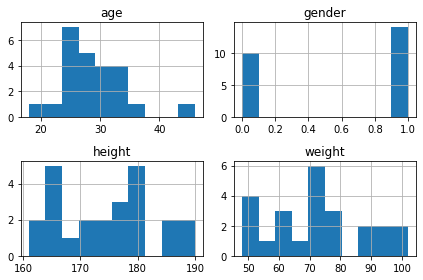

In [7]:
metadata.hist()
plt.tight_layout()

In [8]:
print('Dataset size:', len(dataset))

sample, _, _ = dataset[0]
print('Datapoints shape:', sample.shape)

Dataset size: 4095
Datapoints shape: (256, 12)


Our dataset is composed of 5205 datapoints, each have shape `(256, 12)` because we have 12 signals of 256 samples each.

For our base line model we will use the **user-acceleration magnitude**.
The x,y,z components of the feature are stored on the last 3 columns, se we'll take those and get the magnitude/norm:

In [9]:
X = np.array([np.hstack([np.linalg.norm(sample[:,-3:], axis=1)] + metadata) for sample, _, metadata in dataset])

In [10]:
X.shape

(4095, 260)

Now we "only" have 256 samples per datapoint.

Instead of directly using its value at each timestep, we will apply the Fourier transform and use the frequency domain as our input space.

In [11]:
X_fft = np.fft.fft(X[:,:256], axis=1)

print('Shape:', X_fft.shape)

Shape: (4095, 256)


The output of the Fourier transform is complex, we can take the norm to use real numbers. This will make it simetric so we can use only the positive frequencies.

In [12]:
X_fft = np.abs(np.fft.rfft(X, axis=1))

print('Shape:', X_fft.shape)

Shape: (4095, 131)


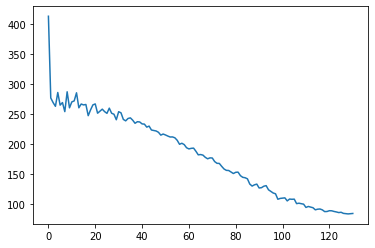

In [13]:
plt.plot(X_fft[7]);

### Classes

The classes are the following:

In [14]:
dataset.CLASSES

{'dws': 'down-stairs',
 'ups': 'up-stairs',
 'wlk': 'walk',
 'std': 'standing',
 'sit': 'sitting',
 'jog': 'jogging'}

In order to fit a `sklearn` model we should encode each class with a unique integer:

In [15]:
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(list(dataset.CLASSES.keys()));

In [16]:
y = label_encoder.transform([cls for _, cls, _ in dataset])

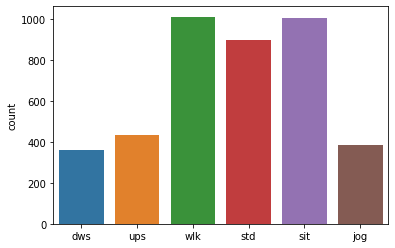

In [17]:
sns.countplot(label_encoder.inverse_transform(y));

#### Train-test splitting

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [19]:
print('Number of training examples:', y_train.shape[0])
print('Number of testing examples:', y_test.shape[0])

Number of training examples: 3276
Number of testing examples: 819


#### PCA feature reduction

In [20]:
pca = sklearn.pipeline.make_pipeline(
    FourierTransform(),
    # sklearn.preprocessing.StandardScaler(),
    PCA(n_components=32)
)

#### Join data with metadata

In [21]:
features = sklearn.compose.ColumnTransformer([
    ('fft_pca', pca, slice(0, -4)),
    ('metadata', 'passthrough', slice(-4, X.shape[1]))
])

## Visualization

In [22]:
X_feats = features.fit_transform(X_train)

In [23]:
X_feats.shape

(3276, 36)

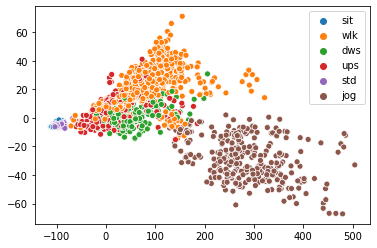

In [24]:
sns.scatterplot(x=X_feats[:,0], y=X_feats[:,1], hue=label_encoder.inverse_transform(y_train));

The classes seem VERY overlapped (except for the jog class), so the results are not promising.

## Support vector machine

In [25]:
import sklearn.svm

In [26]:
clf = sklearn.pipeline.make_pipeline(
    features,
    sklearn.svm.SVC()
)
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('fft_pca',
                                                  Pipeline(memory=None,
                                                           steps=[('fouriertransform',
                                                                   FourierTransform(window=None)),
                                                                  ('pca',
                                                                   PCA(copy=True,
                                                                       iterated_power='auto',
                                                                       n_components=32,
                                                                       random_state=None,
         

In [27]:
print(classification_report(y_train, clf.predict(X_train), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       0.84      0.76      0.80       281
         jog       0.99      0.99      0.99       308
         sit       0.62      0.96      0.75       810
         std       0.89      0.34      0.49       732
         ups       0.78      0.78      0.78       345
         wlk       0.94      0.97      0.95       800

    accuracy                           0.79      3276
   macro avg       0.84      0.80      0.79      3276
weighted avg       0.83      0.79      0.77      3276



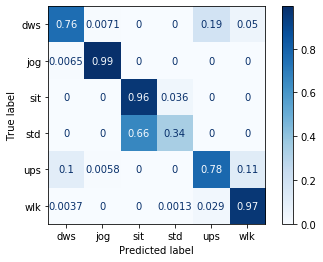

In [28]:
plot_confusion_matrix(clf, X_train, y_train,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")

In [29]:
print(classification_report(y_test, clf.predict(X_test), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       0.85      0.64      0.73        78
         jog       0.99      1.00      0.99        76
         sit       0.61      0.96      0.75       194
         std       0.86      0.30      0.45       168
         ups       0.72      0.82      0.77        91
         wlk       0.94      0.96      0.95       212

    accuracy                           0.78       819
   macro avg       0.83      0.78      0.77       819
weighted avg       0.82      0.78      0.76       819



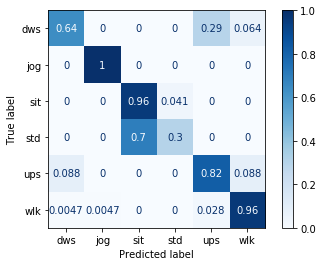

In [30]:
plot_confusion_matrix(clf, X_test, y_test,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")

## Cross-validates parameter search

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

In [32]:
cv = ShuffleSplit(n_splits=5, test_size=0.15, random_state=0)
scores = cross_val_score(clf, X, y, cv=cv)
scores

array([0.76585366, 0.81788618, 0.77560976, 0.77398374, 0.77886179])

In [33]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.78 (+/- 0.04)


### Hyper-parameter search

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
clf = sklearn.pipeline.make_pipeline(
    features,
    sklearn.svm.SVC()
)

In [36]:
param_grid =  {
    'svc__C': [1, 10, 100, 1000],
    'svc__gamma': [0.001, 0.0001],
    'svc__kernel': ['rbf']
}

In [37]:
grid_search = GridSearchCV(clf, param_grid, cv=cv)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.15, train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('fft_pca',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('fouriertransform',
                                                                                          FourierTransform(windo...
                                            decision_func

In [38]:
grid_search.best_params_

{'svc__C': 1000, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

In [39]:
grid_search.best_score_

0.8865853658536584

In [40]:
import pandas as pd

In [41]:
cv_results = pd.DataFrame(grid_search.cv_results_)

In [42]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.701011,0.151968,0.073998,0.003569,1,0.001,rbf,"{'svc__C': 1, 'svc__gamma': 0.001, 'svc__kerne...",0.865854,0.863821,0.843496,0.833333,0.869919,0.855285,0.014280,6
1,0.302042,0.054867,0.061683,0.004180,1,0.0001,rbf,"{'svc__C': 1, 'svc__gamma': 0.0001, 'svc__kern...",0.837398,0.806911,0.798780,0.796748,0.855691,0.819106,0.023387,8
2,0.592650,0.082120,0.069373,0.006881,10,0.001,rbf,"{'svc__C': 10, 'svc__gamma': 0.001, 'svc__kern...",0.873984,0.880081,0.853659,0.843496,0.890244,0.868293,0.017218,5
3,0.319794,0.020672,0.063717,0.013580,10,0.0001,rbf,"{'svc__C': 10, 'svc__gamma': 0.0001, 'svc__ker...",0.863821,0.861789,0.819106,0.837398,0.884146,0.853252,0.022611,7
4,0.579148,0.088405,0.066086,0.009052,100,0.001,rbf,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__ker...",0.878049,0.888211,0.861789,0.869919,0.898374,0.879268,0.012957,2
5,0.256807,0.018695,0.043514,0.000911,100,0.0001,rbf,"{'svc__C': 100, 'svc__gamma': 0.0001, 'svc__ke...",0.878049,0.871951,0.855691,0.857724,0.898374,0.872358,0.015501,3
6,0.791239,0.287063,0.068978,0.021352,1000,0.001,rbf,"{'svc__C': 1000, 'svc__gamma': 0.001, 'svc__ke...",0.876016,0.894309,0.876016,0.880081,0.906504,0.886585,0.012018,1
7,0.458299,0.157240,0.065212,0.026152,1000,0.0001,rbf,"{'svc__C': 1000, 'svc__gamma': 0.0001, 'svc__k...",0.865854,0.876016,0.849593,0.861789,0.898374,0.870325,0.016382,4


### Best results

In [43]:
print(classification_report(y_train, grid_search.predict(X_train), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       1.00      1.00      1.00       281
         jog       1.00      1.00      1.00       308
         sit       0.87      0.95      0.91       810
         std       0.94      0.85      0.89       732
         ups       1.00      1.00      1.00       345
         wlk       1.00      1.00      1.00       800

    accuracy                           0.95      3276
   macro avg       0.97      0.97      0.97      3276
weighted avg       0.95      0.95      0.95      3276



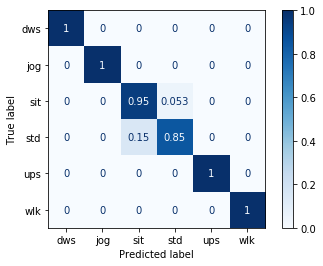

In [44]:
plot_confusion_matrix(grid_search, X_train, y_train,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")

In [45]:
print(classification_report(y_test, grid_search.predict(X_test), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       0.92      0.83      0.87        78
         jog       0.90      1.00      0.95        76
         sit       0.82      0.90      0.86       194
         std       0.87      0.77      0.81       168
         ups       0.87      0.90      0.89        91
         wlk       0.97      0.95      0.96       212

    accuracy                           0.89       819
   macro avg       0.89      0.89      0.89       819
weighted avg       0.89      0.89      0.89       819



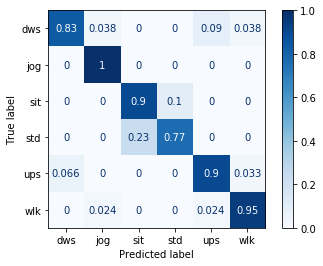

In [46]:
plot_confusion_matrix(grid_search, X_test, y_test,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")

### Test

In [47]:
from utils import classify_time_series
from dataset import HARDataset

In [48]:
dataset_test = HARDataset('motionsense-dataset/test', metadata_file='motionsense-dataset/data_subjects_info.csv')

In [51]:
y_pred = [classify_time_series(np.linalg.norm(x[:, -3:], axis=1), grid_search, 256, meta)
          for x, _, meta in dataset_test]
y_true = label_encoder.transform([cls for _, cls, _ in dataset_test])

In [52]:
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       0.55      0.80      0.65        15
         jog       0.77      1.00      0.87        10
         sit       0.75      0.30      0.43        10
         std       0.56      0.90      0.69        10
         ups       0.88      0.47      0.61        15
         wlk       0.92      0.73      0.81        15

    accuracy                           0.69        75
   macro avg       0.74      0.70      0.68        75
weighted avg       0.74      0.69      0.68        75

